# Homework 1

The main goal of this homework is to get you set up and aquinted with our programming and experimentation evinorment, namely Python, Jupiter and NumPy, as well as with working with both synthetic and real data.  We will also learn about, implement, and experiment with, the nearest neighbour learning rule.

Throughout the homeworks, we will have programming and experimentation **tasks** as well as some **questions** you will need to answer.
- For **tasks**, you will need to either **add code between comments "`#### TASK N CODE`"** to complete them or **modify code between those comments**. **DO NOT delete the comments "#### TASK N CODE". This is for graders' reference and you might not get full points if you tamper with these comments.**
- For **questions**, you will need to answer in a few sentences between the given lines.
- For **optional tasks**, you are **NOT required to turn them in**. However, we encourage you to complete them as they are good practice.
- For **challenge-optional tasks**, you are **NOT required to turn them in**. However, you will receive extra credit for completing the challenge.

-----

## Preparation

First, we will install the libraries we will need in this homework.  This should not be necesairy if using Colaboratory or a full Anaconda installation.

In [ ]:
!pip install matplotlib numpy

Now download *utils.py*, which contains helper functions we defined (you can peek into this module, but are not required to do so and can just use it as a black box):

In [ ]:
!gdown 1GnseL1kj-KrMb9WiaDu6M5-dVFIioBWo

Downloading...
From: https://drive.google.com/uc?id=1GnseL1kj-KrMb9WiaDu6M5-dVFIioBWo
To: /content/utils.py
100% 4.85k/4.85k [00:00<00:00, 12.8MB/s]


Now import the relevant libraries.
- `numpy` [[documentation](https://numpy.org/doc/stable/reference/index.html)] is a package of numerical and scientific computing in Python.  Most importantly, it provides a multi-dimensional array object that can be used to represent vectors, matrices and data.  We will use numpy extensively.
 If you are not yet familiar with numpy, you might want to look at its [[quickstart guide](https://numpy.org/doc/stable/user/quickstart.html)] and/or other tutorials on its use.  As is common, we are naming the imported module by the shortened name `np`.
- We will use the (sub)module `matplotlib.pyplot` [[documentation](https://matplotlib.org/stable/index.html)] for plotting and visualization (naming the imported module `plt`).
- `typing` is a module to add type annotations in a Python, i.e. specify what type (integers, array, float, etc) each variable should be. Python does not enforce types but `typing` [[documentation](https://docs.python.org/3/library/typing.html)] allows us to add hints which can be used for debugging, documentation and more; e.g., here's [how Dropbox integrated type checking to their Python codebase](https://dropbox.tech/application/our-journey-to-type-checking-4-million-lines-of-python). Although we try to add type hints to make our code easier to understand, this is entirely optional for you--you are not required to add type hints to your code and can ignore ours.  )
- `utils` is a module we wrote that contains helper functions we will use ocaisionally in the course, e.g. for generating and plotting data. Feel free to skim through the module.

In [ ]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import utils

We will be using Python's random number generating extensively in this homework. A `seed` is used to initialize the generating process, and specifying one at the beginning ensures that the random numbers generated during execution of some code are the same _across_ runs (not that every random number _in a single run_ is the same) when the execution environment is unaltered. This helps with reproducing results when someone uses the code with the same package version installed. Being able to reproduce a scientific result is extremely important to reviewing and verifying the correctness of research work. Here we initialize `numpy`'s random number generator with a seed.

In [ ]:
seed = 91784073
np.random.seed(seed)

### Generate Data

We will first generate some synthetic data using a function, `generate_spiral_data` from our `utils` module.  

In [ ]:
help(utils.generate_spiral_data)

Help on function generate_spiral_data in module utils:

generate_spiral_data(m: int, noise_level: float = 0.0, theta_sigma: float = 0.0, r_sigma: float = 0.0) -> Tuple[numpy.ndarray, numpy.ndarray]
    Generates m spiral data points from a distribution specified with theta_sigma
    and r_sigma. Labels are in {-1, +1}. With probability noise_level,
    each label is replaced with a random label.



The function draws `m` iid samples from a source distribution over $\mathbb{R}^2 \times \{\pm 1\}$ specified by the remaining parameters.

In [ ]:
LABELS = [-1, 1]
SP_THETA_SIGMA = 0.3
SP_R_SIGMA = 0.05
NOISE_LEVEL = 0.2

m = 1000
Xsp, ysp = utils.generate_spiral_data(m, noise_level=NOISE_LEVEL, theta_sigma=SP_THETA_SIGMA, r_sigma=SP_R_SIGMA)

Lets see what this distribution looks like!

In [ ]:
def scatter_plot(X, y, **plot_kwargs):
    plt.figure(figsize=(8, 6))
    for i, l in enumerate(LABELS):
        l_idxs = np.where(y == l)
        plt.scatter(X[l_idxs, 0], X[l_idxs, 1], label=l, c=utils.cmap_fg[i], **plot_kwargs)
    plt.xlabel('$x_1$') # matplotlib allows basic latex in rendered text!
    plt.ylabel('$x_2$')
    plt.legend(title='label')

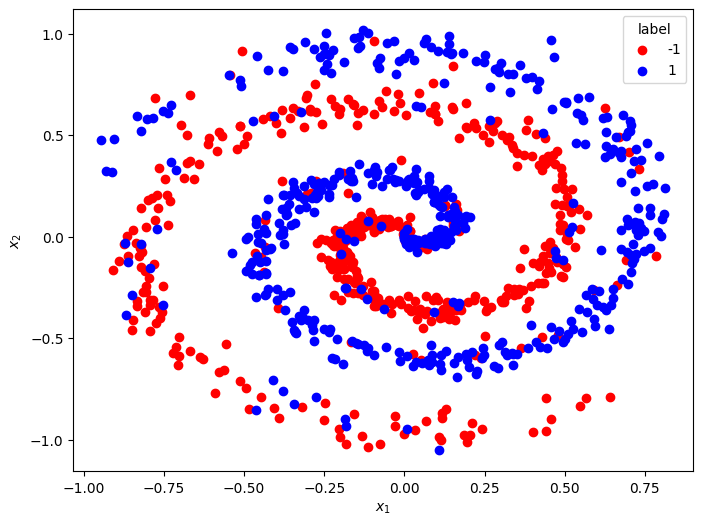

In [ ]:
scatter_plot(Xsp, ysp)

### [Task 1] Split the Dataset into Train and Test Sets

When experimenting with machine learning on a data set, it is useful to partition the data set into disjoint *training* and *test* sets.  We can then play the "game" of learning using the *training* set, and then predicting the labels of the points in the *test* set.  Reserving a portion of the data as a test set also allows us to estimate the generalization error of a learned predictor before using it or shipping it (more on this in Homework 2).

In this assignment, we will use 80% of the data as the training set, and the rest as the test set.  Use the provided function below to generate a random train/test split of the data, defining the parmeter `train_test_ratio` appropriately.



In [ ]:
# The type annotations f(a: t) -> t' mean that input a has type t and f returns something of type t'
# Type annotations are optional in python and is mostly to aid in debugging and reading code.
# In create_split, X and y are numpy arrays, split_ratio has type float,
# and the function returns a tuple of 4 elements, each of which is a numpy array
# (possibly of different shapes). Feel free to ignore the types if you find them confusing

def create_split(X: np.ndarray, y: np.ndarray, split_ratio: float, seed = 310202024) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    Randomly splits (X, y) into sets (X1, y1, X2, y2) such that
    (X1, y1) contains split_ratio fraction of the data. Rest goes in (X2, y2).

    Args:
        X: data features of shape (m, d)
        y: data labels of shape (m)
        split_ratio: fraction of data to keep in (X1, y1) (must be between 0 and 1)
        seed (defaults to the arbirtrary number 31020): a seed to use for the random number generator.
        Using a hard coded seed ensures the same split every time the function is called.

    Returns:
        (X1, y1, X2, y2): each is a numpy array
    '''
    assert 0. <= split_ratio <= 1.
    assert X.shape[0] == len(y)
    assert len(y.shape) == 1

    m = X.shape[0]
    # The following line creates an independent source of psuedo-random numbers, which doesn't
    # affect subequent number generation that won't use the created rng.  We use this so that we
    # can get consistent splits in this routine, by using a fixed seed, without making subsequent
    # random numbers also be the same on each execution.
    rng = np.random.default_rng(seed)
    idxs_shuffled = rng.permutation(m)
    X_shuffled, y_shuffled = X[idxs_shuffled], y[idxs_shuffled]

    m1 = int(split_ratio * m)
    X1, y1 = X_shuffled[:m1], y_shuffled[:m1]
    X2, y2 = X_shuffled[m1:], y_shuffled[m1:]

    return (X1, y1, X2, y2)

#### TASK 1 CODE
train_test_ratio = 0.8
#### TASK 1 CODE

Xsp_train, ysp_train, Xsp_test, ysp_test = create_split(Xsp, ysp, train_test_ratio)

print(len(Xsp_train),len(ysp_train),len(Xsp_test),len(ysp_test))

800 800 200 200


## Nearest-Neighbor Predictor

Now we will implement a Nearest Neighbor predictor using the Euclidean distance between points as a distance measure.  That is, the predict label for a point `x`, is the label of the point closest (in Euclidean distance) to `x` in the training set.

**There is a minor bug in the implementation! You should correct it in this task and say what it was at the end of the code cell.** We also provide a function to calculate the decision boundary of a predictor, which can be helpful in debugging.

To predict the label for a test point, we will need to calculate its distance to each of the training points. Since our data is expressed as vectors and vector/matrix operations are optimized under-the-hood with `numpy` functions, we will favor using matrix operations over loops to predict for $n$ test points. Here is an algorithm for making predictions test set $\mathbf{X} \in \mathbb{R}^{n \times d}$ using a training set $\mathbf{Z} \in \mathbb{R}^{m \times d}$ for $d$-dimensional data:

1. Calculate distance of each test point $x_i$ from each training point $z_j$. This distance is $d_{ij} = \lVert x_i - z_j \rVert_2$. Consider expanding the expression as
$$
d_{ij}^2 = \left( x_i - z_j \right)^\top \left( x_i - z_j \right) = x_i^\top x_i + z_j^\top z_j - 2 x_i^\top z_j = s_{ij} + r_{ij} - 2 g_{ij}
$$
Thus, to get the squared-distance matrix $\mathbf{D}^2 \in \mathbb{R}^{n \times m}$ with elements $d_{ij}^2$, we will create matrices $\mathbf{S}, \mathbf{R}, \mathbf{G}$ such that $s_{ij} = x_i^\top x_i, r_{ij} = z_j^\top z_j, g_{ij} = x_i^\top z_j$ (mind the indices).
2. Find the indices of the nearest training points for each test point $x_i, \forall i \in [n]$.
3. Map the indices of the training data to training labels.

We will use a consitent interface for learning rules and predictors throughout the course.  Learning rules are objects with the method `fit` which take as input the training set and update the object to be the learned predictors (this is where training happens), and a method `predict` which takes as input (test) points and returns their predicted labels.  In our case, there is not much happening during training time: we just memorize the training set by saving it into the object.  All the action happens at test-time in the method `predict`.  For most learning rules we'll see later on, most of the action happens at training time, inside `fit`.

### [Task 2] Fix the bug in the Nearest-Neighbor predictor

In [ ]:
from scipy import stats

#### TASK 2 CODE: Correct the bug in the code above and add a comment here briefly indicating the fix
class NearestNeighborPredictor:
    '''
    Use as:
        ```
        nn_clf = NearestNeighborPredictor() # Nearest neighbor predictor
        nn_clf.fit(X_train, y_train)
        y_test_predict = nn_clf.predict(X_test)
        ```
    '''
    def __init__(self):
        # Need to save the training points for prediction
        self.X_train = None
        self.y_train = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        '''
        Trains a Nearest Neighbor predictor on training data (X, y).

        Args:
            X: data features
            y: data labels
        '''
        # Save the training points; to be used during prediction
        self.X_train = X
        self.y_train = y

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''
        Predicts the labels for data X using the trained predictor.

        Args:
            X: data features

        Returns:
            y: labels, same number as the data points
        '''
        assert (self.X_train is not None) and (self.y_train is not None), '1NN not trained!'
        n_test = len(X)
        n_train = len(self.X_train)

        # x_i^T x_i is the dot product of x_i with itself; can be calculated by
        # squaring each x_{ij} and summing over j dimensions
        S = np.sum(X**2, axis=1) # shape (n_test)

        # Similarly calculate z_j^T z_j for the R matrix
        R = np.sum(self.X_train**2, axis=1) # shape (n_train)

        # x_i^T z_j is the inner product between matrices X and Z, giving
        # G_{ij}
        G = X @ self.X_train.T # shape (n_test, n_train)

        # Use broadcasting to calculate D2. Reference: https://numpy.org/doc/stable/user/basics.broadcasting.html
        # Need to replicate S_i n_train times along the column dimension
        # and replicate R_j n_test times along the row dimension before adding them
        # to get S_{ij} = x_i^T x_i and R_{ij} = z_j^T z_j. These can then be added to get D2
        # With broadcasting, we can do this by adding a placeholder column axis
        # to S and placeholder row axis to R before adding them.
        D2 = S[:, np.newaxis] + R[np.newaxis, :] - 2 * G

        # Now get the index of the nearest training point
        # np.argsort returns the indices for sorting a matrix's elements along an axis
        # in ascending order; pick the nearest neighbor
        one_nearest = np.argsort(D2, axis=1)[:, :1] # shape (n_test, 1)

        # Map the training indices to labels
        y = self.y_train[one_nearest] # shape (n_test, 1)

        return y.squeeze()

#### TASK 2 CODE: Correct the bug in the code above and add a comment here briefly indicating the fix
#### The bug and correction:

In [ ]:
nn_clf = NearestNeighborPredictor()
nn_clf.fit(Xsp_train, ysp_train)

### Decision Boundaries
As discussed in Chapter 19 of [UML], classifiers have decision boundaries in the feature space. A classifier divides the feature space into pockets of labels&mdash;we can visualize these pockets by coloring them.

For the spiral data with only two features (coordinates $x_1, x_2$), we can predict the label for each point in the 2d plane and determine where the decisions of a classifier change. We provide you with a helper function `plot_decision_boundary` in the `utils` module, using which we can visualize this neatly. We also plot the training points and the test points. We label the training points with their true labels (a classifier with non-zero training error will get wrong labels!), and clearly show which test points the given classifier gets correct and incorrect.

Decision boundaries are extremely useful in understanding where a classifier is making mistakes.

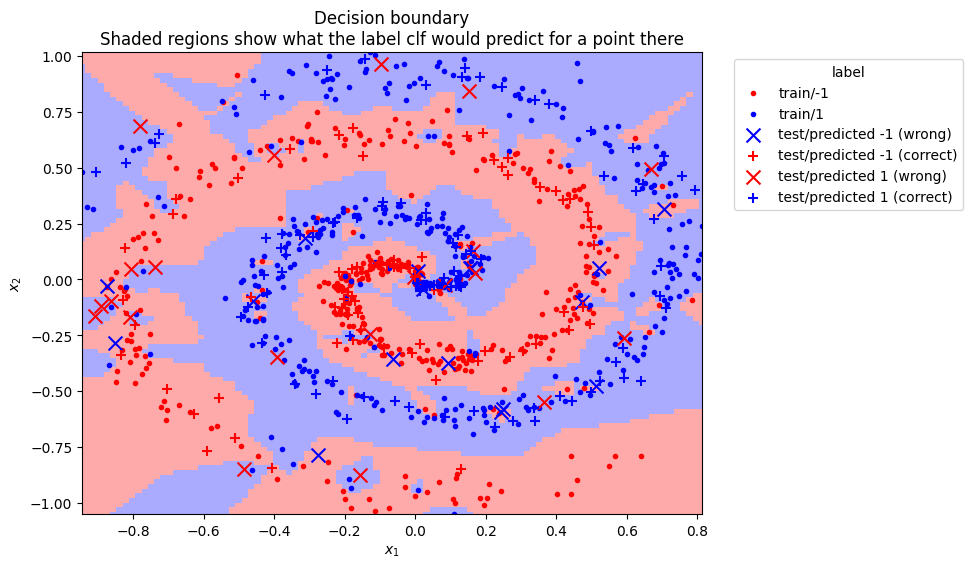

In [ ]:
utils.plot_decision_boundary(nn_clf, Xsp_train, ysp_train, Xsp_test, ysp_test)

### [Task 3] Calculate the Train and Test Errors

Next, you will implement the function `empirical_err` to calculate the empirical error of a trained classifier. We will train a Nearest Neighbor using the class above on spiral data and use your implementation of `empirical_err` to get the train error. Recall that the empirical error $L_S (h)$ of a predictor $h$ on a sample $S = \left\{ \left( x_1, y_1 \right), \dots, \left( x_m, y_m \right) \right\}$ of $m$ data points is given by:
$$
L_S (h) = \frac{\left| \left\{ i \in [m] : h \left( x_i \right) \neq y_i \right\} \right|}{m} = \frac{1}{m} \sum_{i=1}^m \mathbb{1}_{h \left( x_i \right) \neq y_i}.
$$
See also Chapter 2 of course textbook [UML].

In [ ]:
def empirical_err(predictor, X, y):
    """
    Returns the empirical error of the predictor on the given sample.

    Args:
        predictor-- an object with predictor.predict(x) method
        X: array of input instances
        y: array of true (correct) labels

    Returns:
        err: empirical error value
    """
    assert len(X) == len(y)

    #### TASK 3 CODE
    pred_y = predictor.predict(X)
    err = np.mean(y != pred_y)
    #### TASK 3 CODE

    return err

The following simple class will be useful in holding the training and test sets in a single objects, and easily calculating and printing out the training and set errors of a predictor, something we will do frequently.

In [ ]:
class TrainAndTestData:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    def print_errors(self, clf):
        # Get training error
        train_err = empirical_err(clf, self.X_train, self.y_train)
        print(f'Train error: {train_err*100:0.2f}%')
        # Get test error
        test_err = empirical_err(clf, self.X_test, self.y_test)
        print(f'Test error: {test_err*100:0.2f}%')

In [ ]:
spirals = TrainAndTestData(Xsp_train, ysp_train, Xsp_test, ysp_test)

In [ ]:
spirals.print_errors(nn_clf)

Train error: 0.00%
Test error: 19.50%


<span style="color: red">
<h4 style="font-weight: bold">[Answer Questions]</h4>

Sanity check: with a Nearest Neighbor predictor you should have got 0% training error. Why?<br>
<i>Hint: Which points are used to predict for each training point?</i>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: The nearest neighbor of any trainig data sample is itself.
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

## Working with a Real-World Dataset

Next, lets try loading some real data. We will use a SMS Spam dataset for a classification task. First, let's download the data into the `data` directory.

In [ ]:
!mkdir $PWD/data
!gdown 16_ewUNot4JFwRFwBsp1VzqFTutriUrk5 -O $PWD/data/

mkdir: cannot create directory ‘/content/data’: File exists
Downloading...
From: https://drive.google.com/uc?id=16_ewUNot4JFwRFwBsp1VzqFTutriUrk5
To: /content/data/SMSSpamCollection
100% 390k/390k [00:00<00:00, 116MB/s]


In this dataset, the labels are binary (SMS is spam or ham, i.e. not spam), and the data is raw text. You need to implement a predictor to predict whether a message is spam or not given its text content. You may follow the steps below to build your spam predictor.
- Read through some examples of raw data. **It's extremely important you look at your data before you try any perform any Machine Learning task&mdash;the data guides you to look for relevant features.**
- Perform a train-test split before proceeding.
- Define a simple predictor, and do similar experiments as what you did with the synthectic spiral data. There is no correct answer for this question, but you should at least implement a better-than-chance predictor.
- Evaluate and optimize the performance of your spam predictor.
- You are encouraged to experiment with different approaches, of course!

In [ ]:
# Load the data
import os

Xr, yr = utils.read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection'))

Before doing anything with the data, lets see what it looks like.  This is important whenever you start working on data.

In [ ]:
for X, y in zip(Xr[:10], yr[:10]):
    print(f'{y}\t{X}')

-1	Aight will do thanks again for comin out
-1	Nobut heard abt tat
1	Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am11pm as you have WON a guaranteed 1000 cash or 5000 prize
-1	Yeshe is really greatbhaji told kallis best cricketer after sachin in worldvery tough to get out
-1	ltgt  am I think Should say on syllabus
-1	Umma Did she say anything
-1	Give me a sec to think think about it
1	Panasonic  BluetoothHdset FREE Nokia FREE Motorola FREE  DoubleMins  DoubleTxt on Orange contract Call MobileUpd8 on 08000839402 or call 2optout
-1	I dont quite know what to do I still cant get hold of anyone I cud pick you up bout 730pm and we can see if theyre in the pub
-1	Poyyarikaturkolathupalayamunjalur posterode dis ltgt 


Next, we'll create our train and test data split.  Note that the way we implemented create_split, we should be getting the same split every time we call this function (as long as we use the default seed).

In [ ]:
# Split the dataset

# The * notation 'unpacks' the 4-tuple returned by create_split and passes it as four arguments to TrainAndTestData
spamdata = TrainAndTestData(*create_split(Xr, yr, 0.7))

print(len(spamdata.X_train), len(spamdata.y_train), len(spamdata.X_test), len(spamdata.y_test))


2998 2998 1286 1286


### Constant-false predictor

Let's start with a constant-false predictor. That is, the predictor predict -1 (i.e. not spam) to any text message regardless of its content. This is not *Learning*, but any learning methods should surpass this baseline to be considered as meaningful improvements.

In [ ]:
class ConstantFalsePredictor:
    '''
    Use as:
        ```
        constant_clf = ConstantFalsePredictor()
        y_test_predict = constant_clf.predict(X_test)
        ```
    '''
    def __init__(self):
        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''
        Return an array if -1's to any input

        Args:
            X: data features

        Returns:
            y: labels, same number as the data points
        '''

        return np.full(X.shape[0], fill_value = -1)

# You should at least beat this baseline, where we naively predict every SMS as non-spam.
constant_clf = ConstantFalsePredictor()

spamdata.print_errors(constant_clf)

Train error: 12.37%
Test error: 12.75%


### Word conjunction predictor

Then let's define our own spam predictor! Below is an example word-conjunction predictor, where we define a list of ``spam_words``, and the ``WordConjPredictor`` will predict an SMS as spam as long as any word from the ``spam_words`` list is found in the SMS. No matter how you implement your spam predictor, it should at least get a lower test error than the constant-false predictor.

In [ ]:
# This is an example of a simple predictor, which makes predictions based on whether any of the words in 'spam_words' can be found in the sentences
# You can brainstorm different solutions!

class WordConjPredictor:
    '''
    Use as:
        ```
        word_clf = WordConjPredictor()
        word_clf.program_word(word_list)  OR  word_clf.fit(X_train,y_train,num_words,count_threshold)
        y_test_predict = word_clf.predict(X_test)
        ```
    '''
    def __init__(self):
        self.spam_words = []

    def program_words(self, spam_words: List = []):
        '''Hard-code the words that indicate spamness'''
        self.spam_words = spam_words

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''
        Predicts the labels for data X based whether any of the words in self.spam_words can be found in the sentences

        Args:
            X: data features

        Returns:
            y: labels, same number as the data points
        '''
        y = []
        for x in X:
            xsplit = x.lower().split()
            is_spam = -1
            for word in self.spam_words:
                if word in xsplit:
                    is_spam = 1

            y.append(is_spam)

        return np.array(y)

    def fit(self, X_train, y_train, num_words=2, count_threshold=100):
        '''
        Trains the predictor by using the words that minimize the training error.

        Args:
            X_train, y_train: the training set, X_train is an array of strongs, y_train an array of labels
            num_words: number of words in the conjunction (default 2)
            count_threshold: only consider words that appear more than this many times in the training set (default 100)
        '''
        # We're not going to worry about upper/lower case, and only going to worry about which words appear in a message,
        # that is treat each message as a set of words.  So we start by converting each message to lowercase, splitting it
        # into words, and then creating a set object of these words.  The set object is implemented using a hash, making it
        # very fast to check whether it includes an element or not (ie whether the message contains a word)
        X_wordsets = [set(x.lower().split()) for x in X_train] # X_wordset[i] is the set of words in the message X_train[i], converted to lowercase

        # Find all words that appear at least count_threshold times
        from collections import Counter
        c = Counter()
        for x in X_wordsets:
            c.update(x) # addes the words in x to the count
        wordlist = [word for word, count in c.items() if count >= count_threshold]
        print("debug: wordlist length=", len(wordlist))

        # for each word in our wordlist, crease a bolean vector indicating which training messages it is in
        word_appearances = {word:np.array([word in x for x in X_wordsets]) for word in wordlist}
        # for each word in wordlist, word_appearances[word] is a vector of dimensionality len(X_train), where word_appearances[word][i] is True if word appears in X_train[i]

        # Now try all subsets for words with size num_words from wordlist
        import itertools, functools
        best_err = 1.0 # best error so far
        best_words = [] # best wordlist so far
        for words in itertools.combinations(wordlist, num_words):
            # TASK 4 CODE
            pred_y_bool = functools.reduce(np.logical_or, (word_appearances[w] for w in words))
            pred_y = 2*pred_y_bool-1 # True and False are treated as 1 and 0.  We convert this to +1 and -1
            err = np.mean(pred_y != y_train)
            if err < best_err:
                best_words = words
                best_err = err
            # TASK 4 CODE

        # Set words with the lowest training error as self.spam_words,
        # which will later be used in self.predict()
        self.spam_words = best_words

First, use our own obeservations and intuitions to hard code (ie program) a list of ``spam_words`` and evaluate its empirical error on the training and test set.

In [ ]:
spam_words = ["call", "http", "urgent"]
prog_clf = WordConjPredictor()
prog_clf.program_words(spam_words)

spamdata.print_errors(prog_clf)

Train error: 9.91%
Test error: 10.42%


### [Task 4]: Implement the ``fit`` method above

Alternatively, we will learn a good WordConjPredictor using an ERM approach.  To do so, we will use the ``WordConjPredictor.fit()`` method. The method should do the following things:
1. Find out the list of words with more than ``count_threshold`` occurrences in the training set.
2. Iterate over all possible combinations of ``num_words`` words from the word list.
3. Find the word combination with the lowest empirical error on the training set.

To use this method, you need to finish the missing parts in the definition of the method above. A correct implementation shoud result in a training error of less than 8.25%.

In [ ]:
erm_clf = WordConjPredictor()
erm_clf.fit(spamdata.X_train, spamdata.y_train, count_threshold=30, num_words=2)

debug: wordlist length= 216


In [ ]:
spamdata.print_errors(erm_clf)

Train error: 8.14%
Test error: 8.63%


With a good implementation of `WordConjPred.fit()` you should be able to try out also higher `num_words` (3 or maybe 4) and lower `count_thresholds`.

### [Task 5 (Optional)] Find better Conjunctions-of-Words

Try to do a better job at minimizing the training error over all possible word conjunctions.  That is, find the `spam_words` that minimizes the **training error** of `WordConjPredictor` on the data split created. You can do this either by using a faster implementation of exhustive search (e.g. changing just a single word at a time), or a different search heuristic (e.g. pruning the search, trying greedy approaches, or relaxations) or a comninotrial search engine (eg Integer Program and CSP solvers), or perhaps by just using more hardwear or running for longer...

Clarification: you can modify the `fit()` method, but not the `predict()` method.  You must still predict based only on a conjunction of case-insesitive word appearances.

Please clearly specify your idea and approach and comment your code to ensure the readability of your program!

In [ ]:
# TASK 5 CODE
# TASK 5 CODE

Submit the `spam_words` with the lowest training error to the [challange page](https://forms.gle/smfesG8j7EfJZNz69).

### Types of error

When we evaluate the constant-zero predictor, we notice that its error rate is lower than 15%. This implies that the dataset is highly imbalanced -- there is a large gap between the numbers of 1 and -1 labels. For such an imbalanced dataset, aside from empirical error rate, we often look into the **False Positive Rate** and the **False Negative Rate** defined as below:
$$
FPR_S (h) = \frac{\left| \left\{ i \in S_{-1} : h \left( x_i \right) \neq y_i \right\} \right|}{| S_{-1} |}, \text{with } S_{-1} = \{i:y_i=-1\}
$$
$$
FNR_S (h) = \frac{\left| \left\{ i \in S_{1} : h \left( x_i \right) \neq y_i \right\} \right|}{| S_{1} |}, \text{with } S_{1} = \{i:y_i=1\}
$$

In [ ]:
def empirical_false_pos_neg(predictor, X, y):
    '''
    Returns the false-positive and false-negative rates of a predictor.

    Args:
        predictor: an object with predictor.predict(x) method
        X: array of input instances
        y: array of true (correct) labels

    Returns:
        false_pos: false-positive rate
        false_neg: false-negative rate
    '''
    assert len(X) == len(y)
    # variable err should be set to the empirical error

    pred_y = predictor.predict(X)
    false_pos = np.logical_and(pred_y == 1, y == -1).sum() / (y == -1).sum()
    false_neg = np.logical_and(pred_y == -1, y == 1).sum() / (y == 1).sum()

    print(f"False-positive rate {false_pos*100:0.2f}%")
    print(f"False-negative rate {false_neg*100:0.2f}%")

In [ ]:
print("Constant-false predictor")
empirical_false_pos_neg(constant_clf, spamdata.X_test, spamdata.y_test)

print("ERM word conjunction predictor")
empirical_false_pos_neg(erm_clf, spamdata.X_test, spamdata.y_test)

Constant-false predictor
False-positive rate 0.00%
False-negative rate 100.00%
ERM word conjunction predictor
False-positive rate 4.19%
False-negative rate 39.02%


<span style="color: red">
<h4 style="font-weight: bold">[Answer Questions]</h4>

Do you see any differences between the performances of the two different spam predictors, when evaluated with the empherical error rate, and the false-positive/negative rates? How would you explain the meaning of the false-positive/negative rates?

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer:

Some points that could be mentioned:
- The ERM word conjunction predictor has a slightly higher false-positive rate but a much lower false-negative rate that the constant-false predictor, resulting in its lower empirical error.
- False-positive: within the non-spam (negative) samples, how many of them are classified as spam (positive)?
- False-negative: within the spam (positive) samples, how many of them are classified as non-spam (negative)?
- A good classifier strikes a balance between false-positive and false-negative rates.

</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

<span style="color: red">
<h4 style="font-weight: bold">[Answer Questions]</h4>

how would you use the false-positive/negative rates to help you develop your spam predictor?

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: They are useful when analyzing whether your predictor is too aggresive or conservative. For example, when the false-positive rate is too high, you may want to remove some of the `spam_words`.
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

We might also want to try out a Nearest Neighbot approach to SMS spam prediction.  This is tricky, since it requires choosing and implementing an appropriate distance function!  See Task 6 below.

### Looking at the data

You might also want to look at specific mistakes to understand your predictor better, and think of better models and learning rules.



In [ ]:
true_positive, false_positive, true_negative, false_negative = [], [], [], []
y_test_predict = erm_clf.predict(spamdata.X_test)
for X, y_pred, y in zip(spamdata.X_test, y_test_predict, spamdata.y_test):
    if y_pred == 1 and y == 1 and len(true_positive) < 5:
        true_positive.append(X)
    elif y_pred == 1 and y == -1 and len(false_positive) < 5:
        false_positive.append(X)
    elif y_pred == -1 and y == 1 and len(false_negative) < 5:
        false_negative.append(X)
    elif y_pred == -1 and y == -1 and len(true_negative) < 5:
        true_negative.append(X)

print("True-positive spam prediction:")
print("\n".join(true_positive))
print("\nFalse-positive spam prediction:")
print("\n".join(false_positive))
print("\nTrue-negative spam prediction:")
print("\n".join(true_negative))
print("\nFalse-negative spam prediction:")
print("\n".join(false_negative))


True-positive spam prediction:
Shop till u Drop IS IT YOU either 10K 5K 500 Cash or 100 Travel voucher Call now 09064011000 NTT PO Box CR01327BT fixedline Cost 150ppm mobile vary
YOU ARE CHOSEN TO RECEIVE A 350 AWARD Pls call claim number 09066364311 to collect your award which you are selected to receive as a valued mobile customer
UR GOING 2 BAHAMAS CallFREEFONE 08081560665 and speak to a live operator to claim either Bahamas cruise of2000 CASH 18only To opt out txt X to 07786200117
Urgent Urgent We have 800 FREE flights to Europe to give away call B4 10th Sept  take a friend 4 FREE Call now to claim on 09050000555 BA128NNFWFLY150ppm
PRIVATE Your 2003 Account Statement for 07973788240 shows 800 unredeemed S I M points Call 08715203649 Identifier Code 40533 Expires 311004

False-positive spam prediction:
Was doing my test earlier I appreciate you Will call you tomorrow
Hi Dear Call me its urgnt I dont know whats your problem You dont want to work or if you have any other problem at le

### [Task 6 (Challenge-Optional)] Apply Nearest Neighbor to Text Data

In this **challenge-optional** task, you will modify the Nearest Neighbor predictor implementation for the SMS spam prediction data. To achieve this, you will need to define **the distance between two text sequences**, though it might be a little tricky. Here are some possible directions you can try:
- Compute the [Edit distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between two sequences
- Vectorize the sequences and than compute the distance between the vector representations of individual text sequences. You may want to checkout [TF-IDF vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
- Define a set of **keywords**, and than compared the occurances of keywords in each text sequence. Taking a look of the [bag-of-word model](https://en.wikipedia.org/wiki/Bag-of-words_model) may give you some inspirations.

You are encouraged to explore more possibilities. Don't limit yourself to the given solutions!

In [ ]:
#### TASK 6 CODE
#### TASK 6 CODE